In [1]:
# minimal example of learning parameters for a bernoulli distribution with gradient descent
import torch

data_param = 0.876
data_dist = torch.distributions.Bernoulli(data_param)

theta = torch.tensor(0.1, requires_grad=True)
optimizer = torch.optim.SGD([theta], lr=0.01)
n_samples = 100

for i in range(5000):
    data = data_dist.sample((n_samples,))
    optimizer.zero_grad()
    est_param = torch.sigmoid(theta)
    est_dist = torch.distributions.Bernoulli(est_param)
    samples = est_dist.sample((n_samples,))
    samples_log_prob = est_dist.log_prob(samples)

    # diff of total ones among n_samples
    loss = (torch.sum(samples) - torch.sum(data))**2

    # surrogate loss
    loss_sfe = torch.mean(samples_log_prob * loss)
    loss_sfe.backward()
    optimizer.step()
    if i % 500 == 0:
        print(f'{est_param.item():0.3f}')


0.525
0.884
0.874
0.873
0.892
0.876
0.881
0.873
0.894
0.862


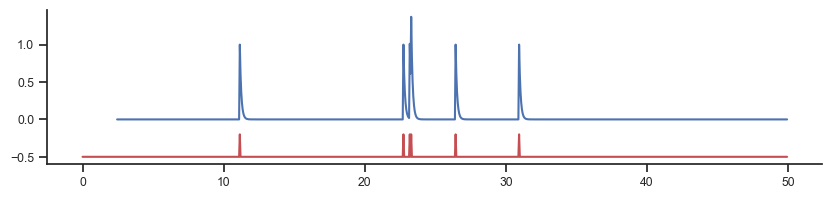

In [2]:
# convolve data and sampled time series with an exponential kernel

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)

sampling_frequency = 20 # Hz
n_samples = 1000
signal_duration = n_samples / sampling_frequency # in seconds
t = np.arange(n_samples) / sampling_frequency # in seconds
exp_decay_constant = 5 # in seconds
spike_freq = 0.2

filter = np.exp(-t/exp_decay_constant)
filter = torch.tensor(np.exp(-t[0:50]/0.1), dtype=torch.float32).reshape(1,1,-1)
filter_flipped = torch.flip(filter, dims=(2,)) # torch conv is cross corr

data_dist = torch.distributions.Bernoulli(spike_freq/sampling_frequency)
data = data_dist.sample((n_samples,))
data_time_series = data.reshape(1,1,-1)
y = F.conv1d(data_time_series, filter_flipped, padding='valid')
shift = data_time_series.shape[2]-y.shape[2]
ty = t[shift:]

f, ax = plt.subplots(figsize=(10,2))
ax.plot(ty,y.numpy().squeeze(), c='b')
ax.plot(t,0.3*data.numpy().squeeze()-0.5, c='r')
plt.show()

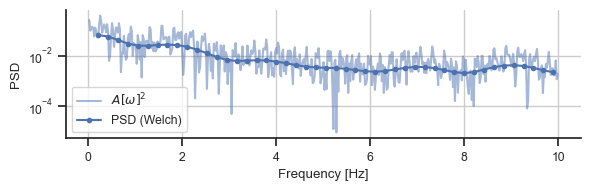

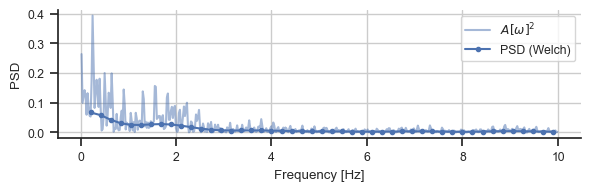

A[w]**2 Delta f = 0.021 Hz
PSD (Welch) Delta f = 0.211 Hz


In [3]:
# construct loss using power spectrum of the convolved time series
from sourcesep.utils.compute import welch_psd

# DFT and squared magnitude
x = y.squeeze() - torch.mean(y.squeeze())
X = torch.fft.rfft(x)
P_X = torch.abs(X)**2 / len(X)
freqs_dft = torch.fft.rfftfreq(y.numel(), d=1/sampling_frequency)
n_per_segment = x.numel()//10
n_overlap = n_per_segment//2
freqs_welch, psd_welch = welch_psd(signal=x,
                                   n_per_segment=n_per_segment, 
                                   n_overlap=n_overlap, 
                                   sampling_freq=sampling_frequency)

# ignore dc component
_, ax = plt.subplots(1,1,figsize=(6, 2))
ax.semilogy(freqs_dft[1:], P_X.numpy()[1:], label=r'$A[\omega]^2$', alpha=0.5)
ax.semilogy(freqs_welch.numpy()[1:], psd_welch.numpy()[1:], label="PSD (Welch)", marker='.', c='b')
ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
ax.grid()
plt.tight_layout()
plt.legend()
plt.show()

_, ax = plt.subplots(1,1,figsize=(6, 2))
ax.plot(freqs_dft[1:], P_X.numpy()[1:], label=r'$A[\omega]^2$', alpha=0.5)
ax.plot(freqs_welch.numpy()[1:], psd_welch.numpy()[1:], label="PSD (Welch)", marker='.', c='b')
ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
ax.grid()
plt.tight_layout()
plt.legend()
plt.show()

print(f'A[w]**2 Delta f = {np.mean(np.diff(freqs_dft)):0.3f} Hz')
print(f'PSD (Welch) Delta f = {np.mean(np.diff(freqs_welch)):0.3f} Hz')

In [4]:
# functions to generate signal and compute psd

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sourcesep.utils.compute import welch_psd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)


def make_signal(sampling_frequency=20,
                n_samples=1000,
                exp_decay_constant=5,
                spike_freq=0.2):

    signal_duration = n_samples / sampling_frequency  # in seconds
    t = np.arange(n_samples) / sampling_frequency  # in seconds

    filter_size = int(exp_decay_constant * sampling_frequency * 3)
    filter = torch.tensor(np.exp(-t[0:filter_size]/exp_decay_constant),
                          dtype=torch.float32).reshape(1, 1, -1)
    filter_flipped = torch.flip(filter, dims=(2,))  # torch conv is cross corr

    data_dist = torch.distributions.Bernoulli(spike_freq/sampling_frequency)
    data = data_dist.sample((n_samples,))
    data_time_series = data.reshape(1, 1, -1)
    signal = F.conv1d(data_time_series, filter_flipped, padding='valid')
    shift = data_time_series.shape[2]-signal.shape[2]
    time = t[shift:]
    return time, signal


def plot_psd(signal, sampling_frequency=20, doplot=True):

    # DFT and squared magnitude
    
    x = signal.squeeze() - torch.mean(signal.squeeze())
    X = torch.fft.rfft(x)
    P_X = torch.abs(X)**2 / len(X)
    freqs_dft = torch.fft.rfftfreq(signal.numel(), d=1/sampling_frequency)
    n_per_segment = x.numel()//20
    n_overlap = n_per_segment//2
    freqs_welch, psd_welch = welch_psd(signal=x,
                                    n_per_segment=n_per_segment, 
                                    n_overlap=n_overlap, 
                                    sampling_freq=sampling_frequency,)

    # ignore dc component
    if doplot:
        _, ax = plt.subplots(1,1,figsize=(6, 2))
        ax.semilogy(freqs_dft[1:], P_X.numpy()[1:], label=r'$A[\omega]^2$', alpha=0.5)
        ax.semilogy(freqs_welch.numpy()[1:], psd_welch.numpy()[1:], label="PSD (Welch)", marker='.', c='b')
        ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
        ax.grid()
        plt.tight_layout()
        plt.legend()
        plt.show()

        _, ax = plt.subplots(1,1,figsize=(6, 2))
        ax.plot(freqs_dft[1:], P_X.numpy()[1:], label=r'$A[\omega]^2$', alpha=0.5)
        ax.plot(freqs_welch.numpy()[1:], psd_welch.numpy()[1:], label="PSD (Welch)", marker='.', c='b')
        ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
        ax.grid()
        plt.tight_layout()
        plt.legend()
        plt.show()

    print(f'A[w]**2 Delta f = {np.mean(np.diff(freqs_dft)):0.3f} Hz')
    print(f'PSD (Welch) Delta f = {np.mean(np.diff(freqs_welch)):0.3f} Hz')
    return freqs_welch.numpy(), psd_welch.numpy()


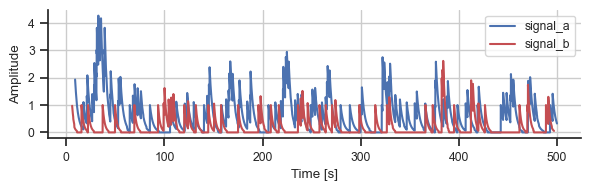

signal_a
A[w]**2 Delta f = 0.002 Hz
PSD (Welch) Delta f = 0.041 Hz


signal_b
A[w]**2 Delta f = 0.002 Hz
PSD (Welch) Delta f = 0.041 Hz


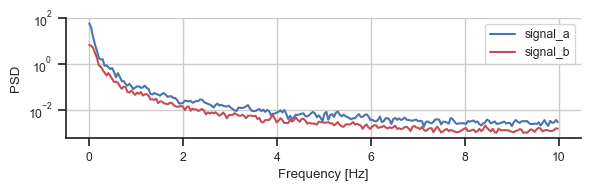

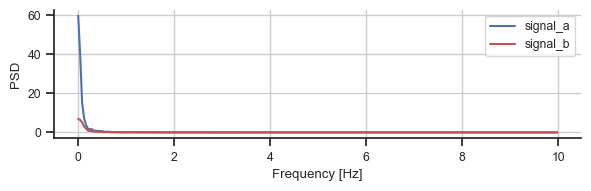

In [5]:
# comparing signals
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sourcesep.utils.compute import welch_psd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)

time_a, signal_a = make_signal(sampling_frequency=20,
                               n_samples=10000,
                               exp_decay_constant=3,
                               spike_freq=0.2)

time_b, signal_b = make_signal(sampling_frequency=20,
                               n_samples=10000,
                               exp_decay_constant=2,
                               spike_freq=0.1)

# filter size is different, so we crop signals to same length
min_length = min(signal_a.shape[2], signal_b.shape[2])
signal_a = signal_a[:, :, :min_length]
signal_b = signal_b[:, :, :min_length]
time_a = time_a[:min_length]
time_b = time_b[:min_length]

_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(time_a, signal_a.numpy().squeeze(), c='b', label='signal_a')
ax.plot(time_b, signal_b.numpy().squeeze(), c='r', label='signal_b')
ax.set(xlabel='Time [s]', ylabel='Amplitude')  # ,xlim = (0,20)
ax.grid()
plt.tight_layout()
plt.legend()
plt.show()

print('signal_a')
f_a, psd_a = plot_psd(signal_a, sampling_frequency=20, doplot=False)
print('\n')
print('signal_b')
f_b, psd_b = plot_psd(signal_b, sampling_frequency=20, doplot=False)

_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.semilogy(f_a, psd_a, c='b', label='signal_a')
ax.semilogy(f_b, psd_b, c='r', label='signal_b')
ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
ax.grid()
plt.tight_layout()
plt.legend()
plt.show()

_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(f_a, psd_a, c='b', label='signal_a')
ax.plot(f_b, psd_b, c='r', label='signal_b')
ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
ax.grid()
plt.tight_layout()
plt.legend()
plt.show()


In [6]:
# Ensure that PSD calculations are performed at the same frequency points = same signal length
# Can a reliable gradient signal be obtained to learn spiking frequency?

In [7]:
# remove above experiments
%reset -f

step:0000:p_spiking=0.398 [Hz] (target = 0.100)  t_decay=1.685 [s] (target=2.00) loss=2.037344  loss_sfe=1.832071


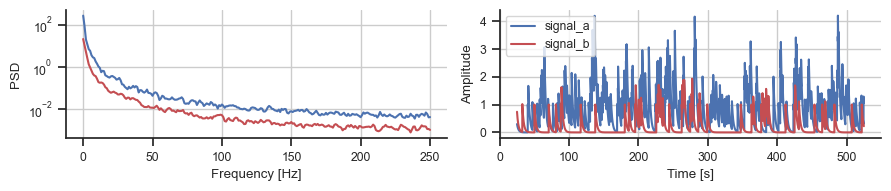

step:1000:p_spiking=0.142 [Hz] (target = 0.100)  t_decay=1.745 [s] (target=2.00) loss=0.210835  loss_sfe=0.201834


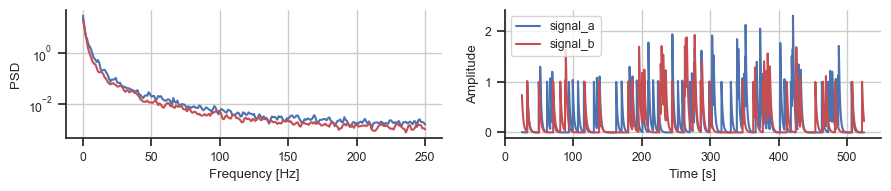

step:2000:p_spiking=0.108 [Hz] (target = 0.100)  t_decay=1.989 [s] (target=2.00) loss=0.061839  loss_sfe=0.059730


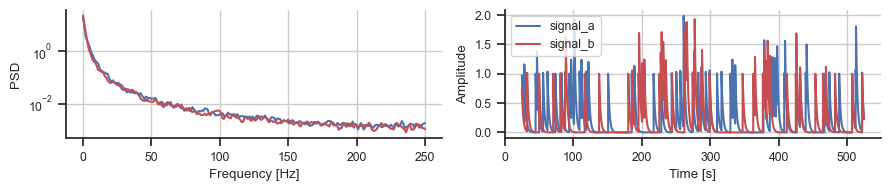

step:3000:p_spiking=0.105 [Hz] (target = 0.100)  t_decay=2.096 [s] (target=2.00) loss=0.073723  loss_sfe=0.071711


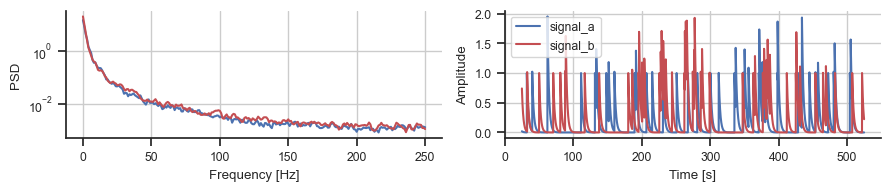

step:4000:p_spiking=0.103 [Hz] (target = 0.100)  t_decay=1.970 [s] (target=2.00) loss=0.048936  loss_sfe=0.047395


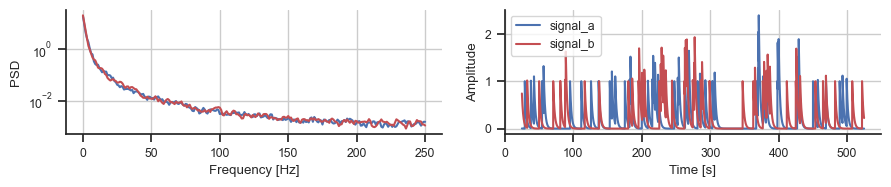

step:5000:p_spiking=0.102 [Hz] (target = 0.100)  t_decay=1.978 [s] (target=2.00) loss=0.071887  loss_sfe=0.069434


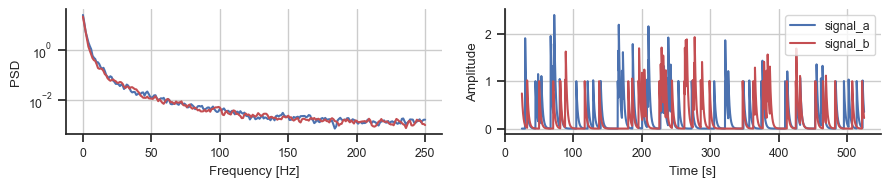

step:6000:p_spiking=0.102 [Hz] (target = 0.100)  t_decay=2.018 [s] (target=2.00) loss=0.146156  loss_sfe=0.140478


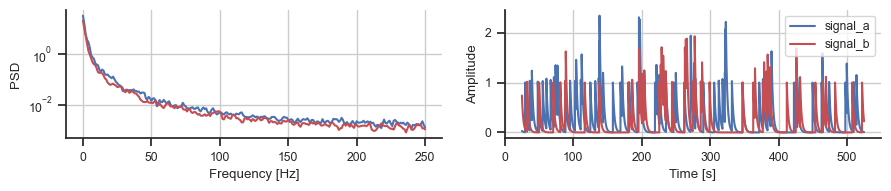

step:7000:p_spiking=0.102 [Hz] (target = 0.100)  t_decay=2.045 [s] (target=2.00) loss=0.051124  loss_sfe=0.049514


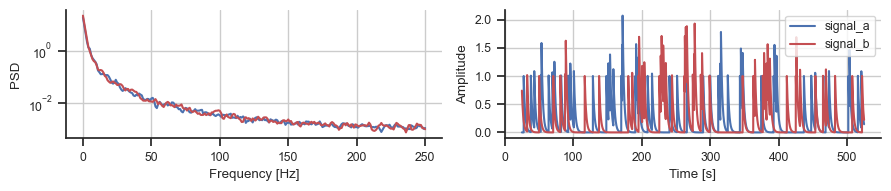

step:8000:p_spiking=0.102 [Hz] (target = 0.100)  t_decay=2.040 [s] (target=2.00) loss=0.066908  loss_sfe=0.064943


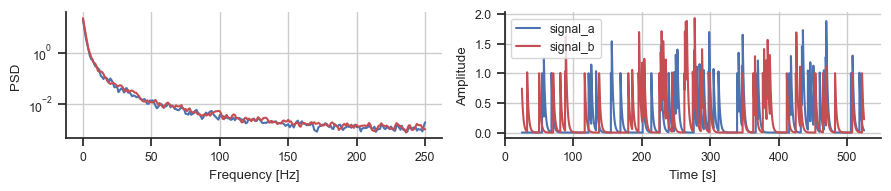

step:9000:p_spiking=0.102 [Hz] (target = 0.100)  t_decay=2.058 [s] (target=2.00) loss=0.063542  loss_sfe=0.061442


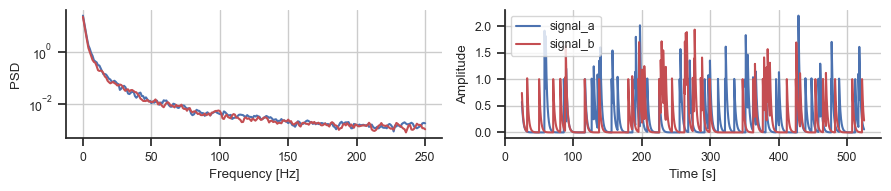

In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sourcesep.utils.compute import welch_psd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)

def make_signal_torch(sampling_frequency=20,
                n_samples=1000,
                exp_decay_constant=None,
                spike_freq=None):

    t = torch.arange(n_samples, dtype=torch.float32) / sampling_frequency  # in seconds
    #filter_size = int(exp_decay_constant * sampling_frequency * 3)
    filter_size = int(sampling_frequency * 25) # fixed filter width
    filter = torch.exp(-t[0:filter_size]/exp_decay_constant).reshape(1, 1, -1)
    filter_flipped = torch.flip(filter, dims=(2,))  # torch conv is cross corr

    distrib = torch.distributions.Bernoulli(spike_freq/sampling_frequency)
    samples = distrib.sample((n_samples,))
    samples_log_prob = distrib.log_prob(samples)
    data_time_series = samples.reshape(1, 1, -1)
    signal = F.conv1d(data_time_series, filter_flipped, padding='valid')
    shift = data_time_series.shape[2]-signal.shape[2]
    time = t[shift:]
    samples_log_prob = samples_log_prob[shift:]
    return time, signal, samples_log_prob

target_spike_prob = 0.1
target_decay_constant = 2.0
sampling_frequency = 20
n_samples=10500

decay_time = lambda x: 5*torch.sigmoid(x)
sigmoid_inv = lambda p: torch.log(p/(1-p))
p=torch.tensor(target_spike_prob + 0.3)
theta_a = sigmoid_inv(p).detach().clone().requires_grad_(True)

p = (1/5)*torch.tensor(target_decay_constant)
phi_a = sigmoid_inv(p).detach().clone().requires_grad_(True)

optimizer = torch.optim.SGD([theta_a, phi_a], lr=10.)

time_b, signal_b, log_probs_b = make_signal_torch(sampling_frequency=sampling_frequency,
                                n_samples=n_samples,
                                exp_decay_constant=target_decay_constant,
                                spike_freq=target_spike_prob)

n_steps = 10000
est_prob = [None]*n_steps
est_decay_time = [None]*n_steps
for i in range(n_steps):
    optimizer.zero_grad()

    time_a, signal_a, log_probs_a = make_signal_torch(sampling_frequency=sampling_frequency,
                                n_samples=n_samples,
                                exp_decay_constant=decay_time(phi_a),
                                spike_freq=torch.sigmoid(theta_a))


    min_length = min(signal_a.shape[2], signal_b.shape[2])
    signal_a = signal_a[:, :, :min_length]
    time_a = time_a[:min_length]
    log_probs_a = log_probs_a[:min_length]
    n_per_segment = min_length // 20
    n_overlap = n_per_segment // 2

    freqs_welch_a, psd_welch_a = welch_psd(signal=signal_a.squeeze(),
                                    n_per_segment=n_per_segment, 
                                    n_overlap=n_overlap, 
                                    sampling_freq=sampling_frequency)

    if i==0:
        # signal_b is fixed beyond the intial crop
        time_b = time_b[:min_length]
        signal_b = signal_b[:, :, :min_length]
        log_probs_b = log_probs_b[:min_length]
    
        freqs_welch_b, psd_welch_b = welch_psd(signal=signal_b.squeeze(),
                                    n_per_segment=n_per_segment, 
                                    n_overlap=n_overlap, 
                                    sampling_freq=sampling_frequency)

    #loss = (torch.sum(signal_a) - torch.sum(signal_b))**2
    loss = torch.mean((torch.log(psd_welch_a) - torch.log(psd_welch_b))**2)
    loss_sfe = torch.mean(log_probs_a * loss) + loss
    loss_sfe.backward()
    optimizer.step()
    est_prob[i] = torch.sigmoid(theta_a).item()
    est_decay_time[i] = decay_time(phi_a).item()

    if i % 1000 == 0:
        print(f'step:{i:04d}:' + \
              f'p_spiking={torch.sigmoid(theta_a).item():0.3f} [Hz] (target = {target_spike_prob:0.3f})  ' + \
              f't_decay={decay_time(phi_a).item():0.3f} [s] (target={target_decay_constant:0.2f}) ' + \
              f'loss={loss.item():0.6f}  ' + \
              f'loss_sfe={loss_sfe.item():0.6f}')

        _, axes = plt.subplots(1, 2, figsize=(9, 2))
        ax = axes[0]
        ax.semilogy(psd_welch_a.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.semilogy(psd_welch_b.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
        ax.grid()

        ax = axes[1]
        ax.plot(time_a.detach().numpy().squeeze(), signal_a.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.plot(time_b.detach().numpy().squeeze(), signal_b.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Time [s]', ylabel='Amplitude')
        ax.grid()
        plt.tight_layout()
        plt.legend()
        plt.show()


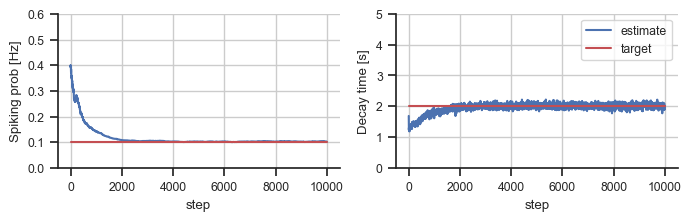

In [9]:
f, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].plot(est_prob, c='b', label='estimate')
ax[0].plot([0, len(est_prob)],[target_spike_prob,target_spike_prob], c='r',label='target')
ax[0].set(xlabel='step', ylabel='Spiking prob [Hz]', ylim=(0,0.6))
ax[0].grid()

ax[1].plot(est_decay_time, c='b', label='estimate')
ax[1].plot([0, len(est_decay_time)],[target_decay_constant,target_decay_constant], c='r',label='target')
ax[1].set(xlabel='step', ylabel='Decay time [s]', ylim=(0,5))
ax[1].grid()
plt.legend()
plt.show()
